In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [114]:
from sklearn.datasets import load_iris

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer

import warnings
warnings.filterwarnings(action='ignore')
sns.set()

# 데이터 Load

In [139]:
dataset = pd.read_excel('/content/drive/MyDrive/핀테크_디지털금융사이언스/수업/클러스터링/Online Retail.xlsx')

# EDA
- object 형은 클러스터에 넣을 수 없다. (나중에 시각화할때 활용, 고객군 분석이나)
- 그럼 일단은 unitPrice, quantity로만 클러스터링 ??
- invoiceDate도 변환해서 클러스터링 할때 사용해야 할까?

In [140]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## null값 처리
- Description은 etc로 처리
- CustomerID는 결측 레코드 삭제

In [141]:
dataset.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [142]:
# 고객수 - 4373명
len(dataset['CustomerID'].unique())

4373

In [143]:
len(dataset['InvoiceNo'].unique())

25900

In [89]:
len(dataset['StockCode'].unique())

3684

In [144]:
# 비회원 삭제
dataset = dataset.dropna(subset = ['CustomerID']).reset_index(drop = True)

In [145]:
dataset.shape

(406829, 8)

In [146]:
# Description은 etc(기타)로 채워준다.
dataset['Description'] = dataset['Description'].fillna('etc')

## InvoiceNo 처리
- 숫자가 아닌 object 처리
- 환불된거 처리

In [147]:
error_NO = set(i[0] for i in dataset['InvoiceNo'].values if re.findall('[^0-9]', str(i)))
print(error_NO)

{'C'}


In [148]:
# C를 포함한 InvoiceNo 처리
dataset['InvoiceNo'] = dataset['InvoiceNo'].apply(lambda x : x if type(x) == int else x[1:])

In [150]:
dataset['InvoiceNo'] = dataset['InvoiceNo'].astype('int64')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406829 entries, 0 to 406828
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  int64         
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 24.8+ MB


## Country는 삭제 안하고 진행

## Quantity
- 거래량이 (-) 데이터 삭제

In [152]:
df = dataset.copy()
df[df['Quantity']<0].shape

(8905, 8)

In [153]:
idx = df[df['Quantity'] < 0].index
print(df.shape)
df = df.drop(idx, axis=0)
print(df.shape)

(406829, 8)
(397924, 8)


## UnitPrice
- 거래대금이 0 데이터 삭제

In [154]:
df[df['UnitPrice']<=0].shape

(40, 8)

In [155]:
idx = df[df['UnitPrice']<=0].index
print(df.shape)
df = df.drop(idx, axis=0)
print(df.shape)

(397924, 8)
(397884, 8)


In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 406828
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  int64         
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 27.3+ MB


# RFM
<pre>
- 가치 있는 고객을 추출해내어 이를 기준으로 고객을 분류할 수 있는 매우 간단하면서도 유용하게 사용될 수 있는 방법으로 얄려져 있어 마케팅에서 가장 많이 사용되는 분석기법

- R (Recency): 최근(InvoiceDate)
- F (Frequency) : 빈도(InvoiceNo, StockCode)
- M (Monetary) : 수량(Quantity*UnitPrice)

## R(Recency) : 최근(InvoiceDate)

In [157]:
df['InvoiceDate'].min(), df['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

In [158]:
df['day_diff'] = df['InvoiceDate'].max() - df['InvoiceDate']

In [159]:
df.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,day_diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,373 days 04:24:00


In [160]:
df['day_diff'] = df['day_diff'].apply(lambda x : x.days+1)

In [161]:
df.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,day_diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,374


In [162]:
df[df['InvoiceDate'] == df['InvoiceDate'].max()].head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,day_diff
406814,581587,22631,CIRCUS PARADE LUNCH BOX,12,2011-12-09 12:50:00,1.95,12680.0,France,1


In [163]:
df = df.set_index('InvoiceDate')
df.head(1)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,day_diff
InvoiceDate,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,374


## F(Frequency) : 빈도(InvoiceNo, StockCode)

In [164]:
df[['InvoiceNo', 'StockCode']].value_counts().head()

InvoiceNo  StockCode
555524     22698        20
           22697        12
572861     22775         8
572344     M             7
578289     23395         7
dtype: int64

## M(Monetary) : 수량(Quantity * UnitPrice)

In [165]:
df['monetary'] = df['Quantity'] * df['UnitPrice']

In [166]:
df.head(1)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,day_diff,monetary
InvoiceDate,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,374,15.3


## User별 RFM 분석
- R : day_diff : max
- F : InvoiceNo, CustomerID : Count
- M : monetary : sum

In [167]:
rfm = df.groupby('CustomerID').agg({'day_diff':'max',
                                    'InvoiceNo':'count',
                                    'monetary':'sum'})

rfm.head(5)

,day_diff,InvoiceNo,monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,367,182,4310.00
12348.0,358,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [169]:
rfm = rfm.reset_index()
rfm.head(1)

,CustomerID,day_diff,InvoiceNo,monetary
0,12346.0,326,1,77183.6


In [170]:
rfm.columns = ['CustomerID', 'R', 'F', 'M']
rfm.head(1)

,CustomerID,R,F,M
0,12346.0,326,1,77183.6


In [171]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4338 entries, 0 to 4337
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  4338 non-null   float64
 1   R           4338 non-null   int64  
 2   F           4338 non-null   int64  
 3   M           4338 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 135.7 KB


In [91]:
# tmp = pd.DataFrame()
# #tmp['customer'] = dataset.groupby('CustomerID')['UnitPrice'].sum().index
# tmp['consume_sum'] = dataset.groupby('CustomerID')['consum_sum'].sum().values
# #tmp['consume_mean'] = dataset.groupby('CustomerID')['consum_sum'].mean().values


# tmp['amount_sum'] = dataset.groupby('CustomerID')['Quantity'].sum().values
# #tmp['amount_mean'] = dataset.groupby('CustomerID')['Quantity'].mean().values


# tmp['Invoice_sum'] = dataset.groupby('CustomerID')['InvoiceNo'].count().values


# 시각화

## 스케일링
- 클러스터링에 학습할 데이터들만 스케일링 진행

In [172]:
# df = tmp.drop('customer', axis=1)
scaler = StandardScaler()
data_scale = scaler.fit_transform(rfm[['R','F','M']])

## 아웃라이어 삭제

In [173]:
data_scale

array([[ 8.71207962e-01, -3.96577702e-01,  8.35866818e+00],
       [ 1.21904030e+00,  3.94648958e-01,  2.50966264e-01],
       [ 1.14268686e+00, -2.65435162e-01, -2.85960063e-02],
       ...,
       [-8.25535142e-01, -3.48492104e-01, -2.08742313e-01],
       [ 9.64528833e-01,  2.90384290e+00,  4.51854273e-03],
       [-1.80772763e-01, -9.49498596e-02, -2.41412739e-02]])

## 최적의 k 개수 구하기

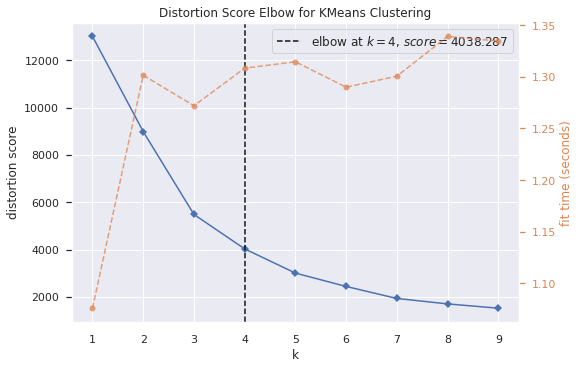

In [174]:
# 최적의 클러스터 개수 구하기
model = KMeans()
visualizer = kelbow_visualizer(model, data_scale, k=(1,10))



## 클러스터 생성 및 시각화

In [175]:
# 데이터 학습
model = KMeans(n_clusters=4, random_state=42)
model.fit(data_scale)

# 클러스터 생성
rfm['cluster'] = model.fit_predict(data_scale)

In [181]:
# scaling 된 데이터프레임
rfm_scale = pd.DataFrame(data_scale, columns=['R','F','M'])
rfm_scale

,R,F,M
0,0.871208,-0.396578,8.358668
1,1.219040,0.394649,0.250966
2,1.142687,-0.265435,-0.028596
3,-1.733293,-0.081836,-0.033012
4,0.735469,-0.326635,-0.191347
...,...,...,...
4333,0.463990,-0.357235,-0.208459
4334,-0.358931,-0.370349,-0.219560
4335,-0.825535,-0.348492,-0.208742
4336,0.964529,2.903843,0.004519


In [182]:
# pca
pca = PCA(n_components=2, random_state=1234)
X_pca = pca.fit_transform(rfm_scale)
X_pca_scaler = scaler.fit_transform(X_pca)
pca_df = pd.DataFrame(X_pca_scaler, columns=["pc1","pc2"])
pca_df['cluster'] = rfm['cluster']
pca_df

,pc1,pc2,cluster
0,4.351193,2.280258,0
1,0.746520,-0.976625,0
2,0.230209,-1.169213,0
3,-0.643523,1.627962,1
4,-0.022223,-0.856333,0
...,...,...,...
4333,-0.138483,-0.610203,0
4334,-0.428111,0.170640,1
4335,-0.568159,0.626986,1
4336,1.857491,-0.225472,0


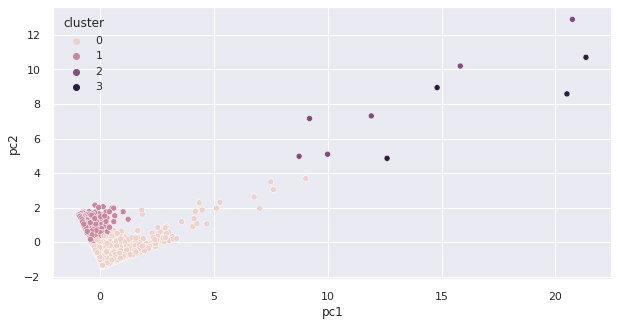

In [183]:
# 스케일링만 진행했을 때 시각화 
plt.figure(figsize = (10, 5))
sns.scatterplot(data = pca_df, x='pc1', y='pc2', hue='cluster')

## 로그 변환후 스케일링 적용해서 시각화

In [186]:
# 로그 변환후 스케일링 적용해서 시각화
rfm2 = rfm[['R','F','M']]
rfm2['R'] = np.log1p(rfm['R'])
rfm2['F'] = np.log1p(rfm['F'])
rfm2['M'] = np.log1p(rfm['M'])

rfm_log_scaler = scaler.fit_transform(rfm2)

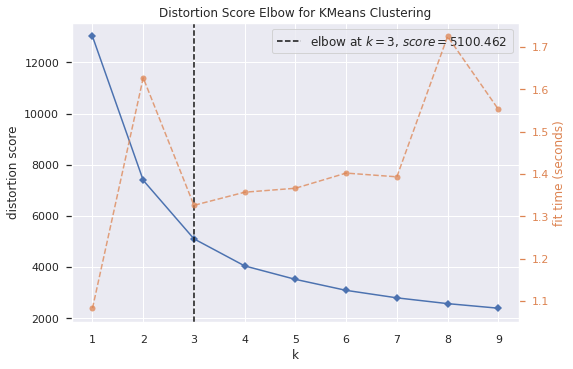

In [187]:
# 최적의 클러스터 개수 구하기
model = KMeans()
visualizer = kelbow_visualizer(model, rfm_log_scaler, k=(1,10))


In [189]:
# 데이터 학습
model = KMeans(n_clusters=4, random_state=42)
model.fit(rfm_log_scaler)

# 클러스터 생성
rfm2['cluster'] = model.fit_predict(rfm_log_scaler)

In [190]:
rfm2_scale = pd.DataFrame(rfm_log_scaler, columns=['R','F','M'])
rfm2_scale

,R,F,M
0,0.720304,-2.434387,3.706225
1,0.853805,1.177483,1.411843
2,0.825821,-0.217054,0.716489
3,-2.437686,0.453387,0.698739
4,0.663606,-0.677192,-0.618962
...,...,...,...
4333,0.540889,-1.071042,-1.106875
4334,0.058069,-1.325720,-1.740933
4335,-0.348593,-0.937443,-1.118121
4336,0.757697,2.313007,0.838297


In [191]:
# pca
pca = PCA(n_components=2, random_state=1234)
X_pca = pca.fit_transform(rfm2_scale)
X_pca_scaler = scaler.fit_transform(X_pca)
pca_df = pd.DataFrame(X_pca_scaler, columns=["pc1","pc2"])
pca_df['cluster'] = rfm['cluster']
pca_df

,pc1,pc2,cluster
0,0.835369,-0.712979,1
1,1.440867,-0.023723,1
2,0.480576,-0.732275,0
3,-0.197831,2.832153,2
4,-0.394965,-1.104006,3
...,...,...,...
4333,-0.835638,-1.265077,3
4334,-1.388634,-1.045166,3
4335,-1.045687,-0.314750,3
4336,1.658625,0.371854,1


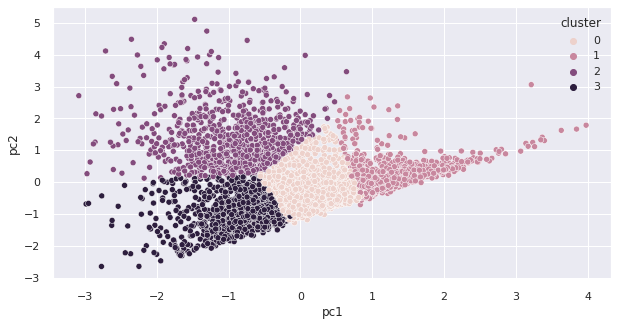

In [192]:
plt.figure(figsize = (10, 5))
sns.scatterplot(data = pca_df, x='pc1', y='pc2', hue='cluster')